# Transformer 

* 원본 link : http://nlp.seas.harvard.edu/2018/04/03/attention.html
* Transformer blog : https://jalammar.github.io/illustrated-transformer/

In [139]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")     # 데이터 시각화 - 사이즈(talk) 선택
%matplotlib inline

## Model Architecture

In [140]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):  
        # memory : keys and values of encoder output
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)    

    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

In [141]:
dataset = torch.Tensor([-2.1018,  0.1694, -0.0844,  0.7305])
print('dataset :', dataset)
print(F.log_softmax(dataset, dim=0))
print(F.log_softmax(dataset, dim=-1))

dataset : tensor([-2.1018,  0.1694, -0.0844,  0.7305])
tensor([-3.5609, -1.2897, -1.5435, -0.7286])
tensor([-3.5609, -1.2897, -1.5435, -0.7286])


## Encoder and Decoder Stacks
### Encoder
Encoder is N=6 layers

In [142]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [143]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, mask):
        # Pass the input (and mask) through each layer in turn
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [144]:
class LayerNorm(nn.Module):
    # Construct a layernorm module
    def __init__(self, features, eps=1e-6):     
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))   # 람다
        self.b_2 = nn.Parameter(torch.ones(features))   # 베타
        self.eps = eps      # 엡실론
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # standard normalization & scale and shift
        return self.a_2*(x-mean)/(std+self.eps) + self.b_2

* 실제 paper와 tensor2tensor code랑 다름

In [145]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm
    Note for code simplicity the norm is first as opposed to last
    Add & Norm
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):     # sublayer + add & norm
        # apply residual connection to any sublayer with the same size
        # SubLayer(x)
        return x + self.dropout(sublayer(self.norm(x)))

In [146]:
class EncoderLayer(nn.Module):
    # Encoder is made up of self-attn and feed forward 
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)    
        self.size = size

    def forward(self, x, mask):
        # Figure 1 left for left connections
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))    # multi-head attention
        return self.sublayer[1](x, self.feed_forward)   

## Decoder

Decoder는 N=6 layers이다.

In [147]:
class Decoder(nn.Module):
    # generic N layer decoder with masking
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [148]:
class DecoderLayer(nn.Module):
    # Decoder is made of src_attn, self_attn, feed_forward
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        # Figure 1 right connections
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))    # multi-head atten Q,K,V
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [149]:
# Decoder > Masked Multi-head Attention 
def subsequent_mask(size):
    # mask out subsequent positions
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')  # 위쪽 삼각형 만들기
    return torch.from_numpy(subsequent_mask) == 0

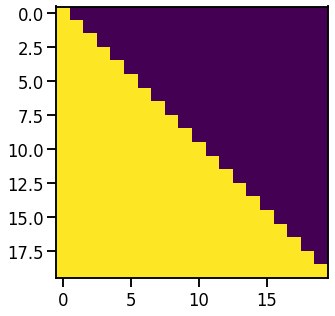

In [150]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

### numpy.triu
상삼각행렬(upper triangular matrix)를 반환한다


In [151]:
a = np.array([[1, 2, 3],[4, 5, 6], [7, 8, 9]])
print('a\n', a, end='\n\n')
print('np.triu(a,1)\n', np.triu(a, 1), end='\n\n')      # 배열의 위쪽 삼각형
print('np.triu(a,-1)\n', np.triu(a, -1), end='\n\n')    # 배열의 아래쪽 삼각형

a
 [[1 2 3]
 [4 5 6]
 [7 8 9]]

np.triu(a,1)
 [[0 2 3]
 [0 0 6]
 [0 0 0]]

np.triu(a,-1)
 [[1 2 3]
 [4 5 6]
 [0 8 9]]



### numpy.ones
1로 가득찬 array를 성성한다
* numpy.ones(shape, dtype, order)
* numpy.ones(shape)

In [152]:
np.ones((1, 2, 4))

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.]]])

### torch.from_numpy()

자동으로 input array의 dtype을 상속받고 tensor와 메모리 버퍼를 공유하기 때문에 tensor의 값이 변경되면 numpy array값이 변경된다.
* 참조 : https://sanghyu.tistory.com/19

In [153]:
a = np.array([1,2,3,4])
b = torch.from_numpy(a)
print('output tensor :', b)

b[0] = -1
print('It can change np.array :', a)

output tensor : tensor([1, 2, 3, 4], dtype=torch.int32)
It can change np.array : [-1  2  3  4]


## Attention

In [154]:
def attention(query, key, value, mask=None, dropout=None):
    # compute 'Scaled dot-product attention'
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

## Multi-head Attention

In [155]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        # take in model size and number of heads
        super(MultiHeadedAttention, self).__init__()
        assert d_model%h==0, 'd_model%h != 0'

        # assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        # Implement Figure 2
        if mask is not None:
            # same mask applied to all h heads
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)    # dim 0차원의 크기

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1,2) for l,x in zip(self.linears, (query,key,value))]

        # 2) Apply attention on all the projected vectors in batch
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "concat" using a view and apply a final inear
        x = x.transpose(1,2).contiguous().view(nbatches, -1, self.h*self.d_k)
        return self.linears[-1](x)


In [156]:
# unsqueeze - 특정 위치에 1인 차원을 추가한다
ft = torch.Tensor([0,1,2])
print('ft.shape:', ft.shape)
print('ft.unsqueeze(0):', ft.unsqueeze(0), ',  shape:', ft.unsqueeze(0).shape, end='\n\n')

# view - 원소의 수를 유지하면서 텐서의 크기(shape)를 변경한다
# view 규칙 1) view는 기본적으로 변경 전과 변경 후의 Tensor 안의 원소의 개수가 유지되어야 한다
# view 규칙 2) view는 사이즈가 설정되면 다른 차원으로부터 해당 값을 유추한다.
ft2 = np.array([[[0, 1, 2],[3, 4, 5]],[[6, 7, 8],[9, 10, 11]]])
ft2 = torch.FloatTensor(ft2)
print('ft2:', ft2, ',  shape:', ft2.shape)

# view를 사용하여 shape을 2차원 텐서로 변경
print(ft2.view([-1, 3]))    # ft라는 텐서를 (?,3) 크기로 변경
print(ft2.view([-1, 3]).shape)  # -1 : 1번째 차원은 사용자가 잘 모르겠으니 PyTorch에 맡기겠다!

# print('ft2.size():', ft2.size())
# print('ft2.size(0):', ft2.size(0))

ft.shape: torch.Size([3])
ft.unsqueeze(0): tensor([[0., 1., 2.]]) ,  shape: torch.Size([1, 3])

ft2: tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.]],

        [[ 6.,  7.,  8.],
         [ 9., 10., 11.]]]) ,  shape: torch.Size([2, 2, 3])
tensor([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9., 10., 11.]])
torch.Size([4, 3])


## Position-wise Feed-Forward Networks

In [157]:
class PositionwiseFeedForward(nn.Module):
    # Implement FFN(x) = max(0, xW1+b1)W2 + b2
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embeddings and Softmax

In [158]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    
    def forward(self, x):
        return self.lut(x)*math.sqrt(self.d_model)

## Positional Encoding

In [159]:
print('torch.arange(0, 10, 2):',torch.arange(0, 10, 2))
print('torch.arange(0, 10, 2)*2:',torch.arange(0, 20, 2)*2)
print('torch.arange(0, 10, 2)*(-2):',torch.arange(0, 20, 2)*(-2))
print('torch.arange(0, 10, 2)*(-4):',torch.arange(0, 20, 2)*(-4))

print('\n ====== The other ====== ')
A = torch.Tensor([0,2,4,6,8])
print(A*2)

torch.arange(0, 20, 2)

torch.arange(0, 10, 2): tensor([0, 2, 4, 6, 8])
torch.arange(0, 10, 2)*2: tensor([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36])
torch.arange(0, 10, 2)*(-2): tensor([  0,  -4,  -8, -12, -16, -20, -24, -28, -32, -36])
torch.arange(0, 10, 2)*(-4): tensor([  0,  -8, -16, -24, -32, -40, -48, -56, -64, -72])

 ====== The other ====== 
tensor([ 0.,  4.,  8., 12., 16.])


tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

In [160]:
torch.exp(torch.arange(0, 512, 2)*(-math.log(10000.0)/512)).shape

torch.Size([256])

In [161]:
class PositionalEncoding(nn.Module):
    # Implement the PE function
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # compute the positional encodings once in log space
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)  
        div_term = torch.exp(torch.arange(0, d_model, 2)*(-math.log(10000.0)/d_model))  # 0, 2, ~ 510 → 총 256개

        pe[:, 0::2] = torch.sin(position*div_term)  # 짝수에는 sin
        pe[:, 1::2] = torch.cos(position*div_term)  # 홀수에는 cos
        pe = pe.unsqueeze(0)    # 0차원에 차원 추가
        self.register_buffer('pe', pe)  # pe는 모델의 매개변수로 간주되지 않는 layer
    
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

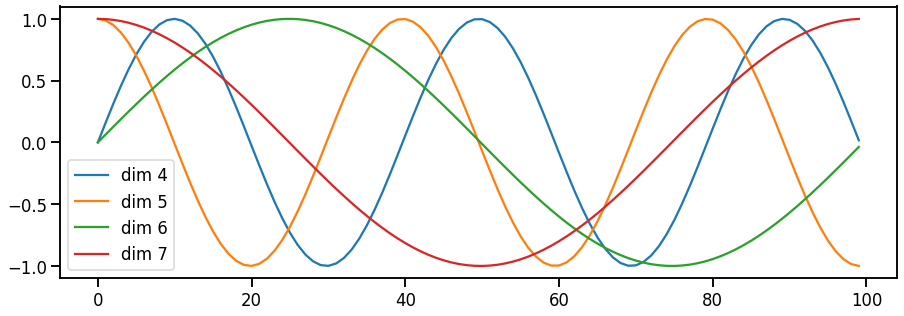

In [162]:
plt.figure(figsize=(15,5))
pe = PositionalEncoding(20,0)
y = pe.forward(Variable(torch.zeros(1,100,20)))
plt.plot(np.arange(100), y[0,:,4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

## Full Model

In [163]:
class Generator(nn.Module):
    # stand linear + softmax generation step
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [164]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    # construct a model from hyperparameters
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )

    # code에서 가장 중요한 부분이다
    # initialize parameters with Glorot/fan_avg
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

# Training

encoder-decoder 모델을 학습시키는데 필요한 몇 가지 도구를 소개하기 위해 잠시 중단한다. <br>
먼저, src와 훈련을 위한 대상 문장을 보유하는 배치 객체를 정의하고 마스크를 구성한다

## Batches and Masking

In [165]:
class Batch:
    # Object for holding a batch of data with mask during training
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        # create a mask to hide padding and future words
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

## Training Loop

In [166]:
def run_epoch(data_iter, model, loss_compute):
    # Standard Training and Loggin Function
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0

    for i,batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)

        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        print('run_epoch - trg:', batch.trg_y, ',  batch.ntokens :', batch.ntokens)

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i%50==1:
            elapsed = time.time() - start
            print("Epoch step: %d Loss: %f Tokens per sec:%f"%(i, loss/batch.ntokens, tokens/elapsed))
            start = time.time()
            tokens = 0
    
    return total_loss/total_tokens

## Training Data and Batching

In [167]:
global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    # keep augmenting batch and calculate total number of tokens + padding
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0

    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.trg) + 2)
    src_elements = count*max_src_in_batch
    tgt_elements = count*max_tgt_in_batch
    return max(src_elements, tgt_elements)

## Optimizer

Note : This part is very important!!!! Need to train with this setup of the model

In [168]:
class NoamOpt:
    # Optim wrapper that implements rate
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        # update parameters and rate
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        # implement `lrate` above
        if step is None:
            step = self._step
        return self.factor*(self.model_size**(-0.5)*min(step**(-0.5), step*self.warmup**(-1.5)))

def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000, torch.optim.Adam(model.parameters(), lr=0, bets=(0.9, 0.98), eps=1e-9))

Examples of the curves of this model for different model sizes and for optimization hyperparameters

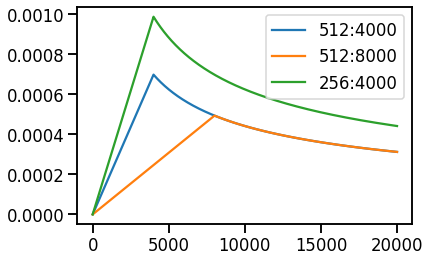

In [169]:
opts = [
    NoamOpt(512, 1, 4000, None),
    NoamOpt(512, 1, 8000, None),
    NoamOpt(256, 1, 4000, None)
]

plt.plot(np.arange(1,20000), [[opt.rate(i) for opt in opts] for i in range(1,20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

## Regularization

### Label Smoothing

KL div loss를 사용하여 label smoothing을 구현한다. one-hot target distribution을 사용하는 대신, correct 단어와 vocab 전체에 분포된 나머지 smoothing mass를 신뢰할 수 있는 분포를 만든다. 

In [170]:
x = torch.Tensor([[1,2,3], [4,5,6], [7,8,9]])
x.fill_(8)

tensor([[8., 8., 8.],
        [8., 8., 8.],
        [8., 8., 8.]])

In [171]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size

        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing/(self.size - 2))

        # debug
        tmp = target.data.unsqueeze(1)
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        
        return self.criterion(x, Variable(true_dist, requires_grad=False))

여기서 어떻게 mass가 confidence를 바탕으로 단어들에 분배되는지 확인할 수 있다

C:\Users\suljeewoo\anaconda3\envs\zeze\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


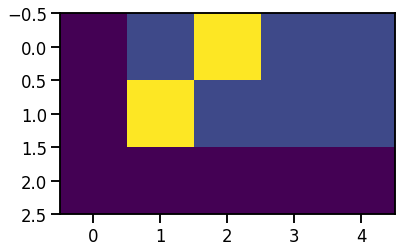

In [172]:
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), Variable(torch.LongTensor([2,1,0])))

plt.imshow(crit.true_dist)

Label smoothing actually starts to penalize the model if it gets very confident about a given choice<br>
Label smoothing은 주어진 선택에 대해 model이 매우 신뢰할 수 있는 경우 model에 penalty를 주기 시작한다

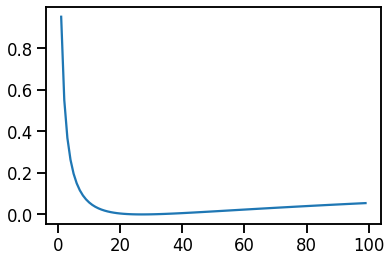

In [173]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x+3*1
    predict = torch.FloatTensor([[0, x/d, 1/d, 1/d, 1/d],])
    return crit(Variable(predict.log()), Variable(torch.LongTensor([1])))

plt.plot(np.arange(1,100), [loss(x) for x in range(1,100)])

# A First Example

작은 vocab에서 임의의 input symbol 집합이 주어지면, 목표는 동일한 symbols를 생성하는 것이다.

### Synthetic Data

In [174]:
def data_gen(V, batch, nbatches):
    # generate random data for a src-tgt copy task
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

### Loss Computation

In [175]:
class SimpleLossCompute:
    # A simple loss compute and train function
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
    
    # instance가 호출됐을 때 실행되는 것이다
    def __call__(self, x, y, norm):
        x = self.generator(x)

        #print('SimpleLossCompute : ', y.contiguous().view(-1).dtype)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1))/norm

        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data[0]*norm


### Greedy Decoding

In [176]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

C:\Users\suljeewoo\anaconda3\envs\zeze\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\SULJEE~1\AppData\Local\Temp/ipykernel_10356/4049937862.py:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


In [177]:
data_gen(V, 30, 20)

<generator object data_gen at 0x0000023D5222DC80>

In [178]:
for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, SimpleLossCompute(model.generator, criterion, None)))

RuntimeError: scatter(): Expected dtype int64 for index

# A Real World Example

## Data Loading
We will load the dataset using torchtext and spacy for tokenization

In [179]:
# For Data loading
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]
    
    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]
    
    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
    TGT = data.Field(tokenize=tokenize_en, init_token=BOS_WORD, eos_token=EOS_WORD, pad_token=BLANK_WORD)

    MAX_LEN = 100
    train, val, test = datasets.IWLST.splits(
        exts=('.de', '.en'), fields=(SRC, TGT),
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN
    )

    MIN_FREQ = 2
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)


OSError: [E941] Can't find model 'de'. It looks like you're trying to load a model from a shortcut, which is obsolete as of spaCy v3.0. To load the model, use its full name instead:

nlp = spacy.load("de_core_news_sm")

For more details on the available models, see the models directory: https://spacy.io/models. If you want to create a blank model, use spacy.blank: nlp = spacy.blank("de")

# 실제 모델

* link : https://opennmt.net/Models-py/
* OpenNMT 오픈소스 프로젝트에서 학습된 모델을 가져옴

In [ ]:
model, SRC, TGT = torch.load("C:/Users/suljeewoo/githubCode/en-de-model.pt")

In [ ]:
model.eval()
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable(src)
src_mask = (src != SRC.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TGT.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TGT.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)

## Attention Visualization

In [ ]:
tgt_sent = trans.split()
def draw(data, x, y, ax):
    seaborn.heatmap(data, xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()

    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()